- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration
- DEWP: Dew Point
- TEMP: Temperature
- PRES: Pressure
- cbwd: Combined wind direction
- Iws: Cumulated wind speed
 Is: Cumulated hours of snow
 Ir: Cumulated hours of rain

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import missingno as msno

# keras
from keras import optimizers
from keras import applications
from keras.optimizers import SGD
from keras.optimizers import RMSprop, Adadelta
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import Sequential, Model 
from keras.utils import np_utils

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import os
import sys
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
#from bokeh.layouts import gridplot
#from bokeh.plotting import figure, show, output_file
#from bokeh.io import output_notebook

#output_notebook()

In [202]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [15, 5], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='darkgrid',rc=rc)

default_color = '#56B4E9'
colormap = plt.cm.cool

In [5]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv('data/international-airline-passengers.csv')

# manually specify column names
df.columns = ['date','passegers']


In [6]:
len_df = len(df)

In [7]:
df.head()

,date,passegers
0,1949-01,112.00
1,1949-02,118.00
2,1949-03,132.00
3,1949-04,129.00
4,1949-05,121.00


In [8]:
df.describe()

,passegers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [9]:
df.isnull().sum()/len_df*100

date        0.00
passegers   0.69
dtype: float64

In [11]:
df = df.dropna()

In [12]:
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m')
df = df.set_index('date')

df.head()

,passegers
date,
1949-01-01,112.00
1949-02-01,118.00
1949-03-01,132.00
1949-04-01,129.00
1949-05-01,121.00


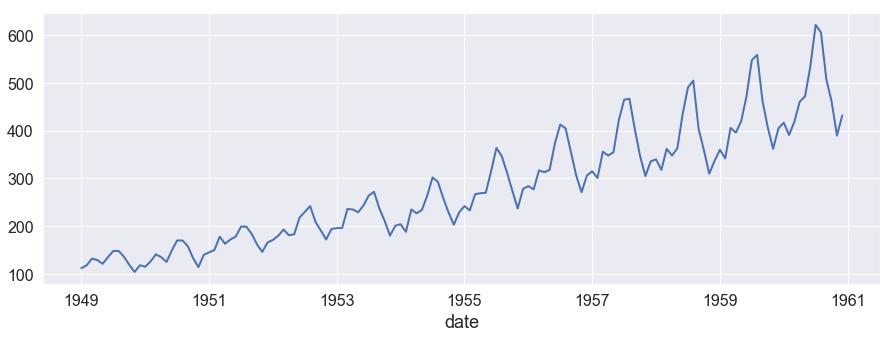

In [203]:
df.passegers.plot()

# LSTM Data Preparation

In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [15]:
cols_shift = ['dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain', 'pollution_var', 'dew_var', 'temp_var', 'press_var',
       'wnd_spd_var', 'snow_var', 'rain_var']

def transform_df(df, f_r = (-1, 1)):
    #for col in cols_shift:
        #df[col] = df[col].shift(1)

    df = df.dropna()

    df = pd.get_dummies(df, drop_first = True)

    scaler = MinMaxScaler( feature_range=f_r )
    df = pd.DataFrame (scaler.fit_transform(df), columns = df.columns )
    
    return df

In [16]:
def create_inputs(data, window_len = 10):
 
    inputs = []
    for i in range(len(data) - window_len):
        temp_set = data[i:(i + window_len)].copy()
        inputs.append(temp_set)
    
    return inputs

def train_test_split(data, y, train_split = 0.7, test_split = 0.15):
    
    train_size = int(len(data)*train_split)
    val_size = int(len(data)*(1 - train_split-test_split))
    test_size = int(len(data)*test_split)
    
    print(train_size)
    print(val_size)
    print(test_size)
    
    x_train = data[:train_size,:,:]
    y_train = y[:train_size]

    x_val   = data[train_size:train_size+val_size,:,:]
    y_val   = y[train_size:train_size+val_size]

    x_test  = data[train_size+val_size:,:,:]
    y_test  = y[train_size+val_size:]

    print(x_train.shape)
    print(y_train.shape)
    print(x_val.shape)
    print(y_val.shape)
    print(x_test.shape)
    print(y_test.shape)

    return x_train,y_train,x_val,y_val,x_test,y_test

In [17]:
def train_plots(training):
    #print('Tempo total de treinamento {:.2f} horas'.format(training.history['tempo (s)']/3600))

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20,7))

    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(training.history['mean_absolute_error'])
    plt.plot(training.history['val_mean_absolute_error'])
    plt.title('mean_absolute_error', fontsize= 30)
    plt.ylabel('mean_absolute_error', fontsize= 20)
    plt.xlabel('epoch', fontsize= 20)
    plt.legend(['treino', 'validação'], loc='upper right', fontsize= 20)
    #plt.ylim((0,1))


    # summarize history for loss
    plt.subplot(1, 2 , 2)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('model loss', fontsize= 30)
    plt.ylabel('loss', fontsize= 20)
    plt.xlabel('epoch', fontsize= 20)
    plt.legend(['treino', 'validação'], loc='upper right', fontsize= 20)
    #plt.ylim((0,1))

    plt.show()

In [18]:
window_len = 30

In [21]:
df2 = transform_df(df)
df2.head()

,passegers
0,-0.97
1,-0.95
2,-0.89
3,-0.90
4,-0.93


In [22]:
y = df2['passegers'].shift(-window_len)
print(len(y))
print(y[:10])

144
0   -0.63
1   -0.63
2   -0.69
3   -0.78
4   -0.84
5   -0.76
6   -0.74
7   -0.71
8   -0.66
9   -0.70
Name: passegers, dtype: float64


In [23]:
y = y.dropna()
len(y)

114

In [24]:
df2 = df2.dropna()
len(df2)

144

In [25]:
data_lstm = create_inputs(df2.values, window_len = window_len)
data_lstm = np.array(data_lstm)
data_lstm.shape

(114, 30, 1)

In [26]:
data_lstm = data_lstm[:len(y),:,:]
data_lstm.shape

(114, 30, 1)

In [27]:
x_train,y_train,x_val,y_val,x_test,y_test = train_test_split(data_lstm,
                                                             y,
                                                             train_split = 0.7, 
                                                             test_split = 0.15)

79
17
17
(79, 30, 1)
(79,)
(17, 30, 1)
(17,)
(18, 30, 1)
(18,)


## Construindo o modelo

The test and validation sets should be standardized with the mean and standard deviation of the training set.
https://arxiv.org/pdf/1808.03314.pdf

Uma celula LSTM
![title](imgs/imagem2.jpg)
fonte: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Vista de dentro:
![title](imgs/imagem3.jpg)
fonte: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

O que é return sequences?
![title](imgs/imagem1.jpg)
fonte: https://adventuresinmachinelearning.com/keras-lstm-tutorial/

In [130]:
def build_model(inputs, output_size, neurons,  dropout, optimizer, loss, activ_func):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
    and finally a dense layer to produce the output using keras' sequential model.
    Return: Keras sequential model and model summary
    """
    model = Sequential()
    # Primeira camada
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    
    # Segunda Camada
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dropout(dropout))
    
    
    # Camada Densa
    model.add(Dense(units=output_size))
    #model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics = ['mae'])
    
    model.summary()
    return model

In [181]:
experimento   = 'teste04'
neurons       = 30           
loss          = 'mean_squared_error'
activ_func    = 'relu'
#optimizer    = Adadelta(lr=0.0001, rho=0.95, epsilon=None, decay=0.0) 
optimizer     = RMSprop(lr=0.0001, rho=0.95, epsilon=None, decay=0.0)
dropout       = 0.25                 
batch_size    = 5               
epochs        = 400                  

# initialise model architecture
model = build_model(x_train, 
                    output_size=1,
                    neurons = neurons,
                    activ_func = activ_func,
                    loss = loss,
                    optimizer = optimizer,
                    dropout=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 30, 30)            3840      
_________________________________________________________________
dropout_76 (Dropout)         (None, 30, 30)            0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_77 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [132]:
callback = ModelCheckpoint( filepath='pesos/weights.'+ experimento +'.hdf5', 
                            verbose=1, 
                            save_best_only=True
                          )

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0, 
                      patience=100, 
                      verbose=2, 
                      mode='auto'
                     )

modelo = model.fit(x_train, 
                    y_train,
                    epochs=epochs, 
                    batch_size=batch_size,
                    verbose=0, 
                    validation_data=(x_val, y_val), 
                    shuffle=False,
                    callbacks=[callback,
                               early 
                              ])


Epoch 00001: val_loss improved from inf to 0.06349, saving model to pesos/weights.teste04.hdf5

Epoch 00002: val_loss did not improve from 0.06349

Epoch 00003: val_loss did not improve from 0.06349

Epoch 00004: val_loss did not improve from 0.06349

Epoch 00005: val_loss did not improve from 0.06349

Epoch 00006: val_loss did not improve from 0.06349

Epoch 00007: val_loss did not improve from 0.06349

Epoch 00008: val_loss did not improve from 0.06349

Epoch 00009: val_loss did not improve from 0.06349

Epoch 00010: val_loss did not improve from 0.06349

Epoch 00011: val_loss did not improve from 0.06349

Epoch 00012: val_loss did not improve from 0.06349

Epoch 00013: val_loss did not improve from 0.06349

Epoch 00014: val_loss did not improve from 0.06349

Epoch 00015: val_loss did not improve from 0.06349

Epoch 00016: val_loss did not improve from 0.06349

Epoch 00017: val_loss did not improve from 0.06349

Epoch 00018: val_loss did not improve from 0.06349

Epoch 00019: val_lo

Epoch 00188: val_loss improved from 0.04926 to 0.04924, saving model to pesos/weights.teste04.hdf5

Epoch 00189: val_loss improved from 0.04924 to 0.04920, saving model to pesos/weights.teste04.hdf5

Epoch 00190: val_loss improved from 0.04920 to 0.04916, saving model to pesos/weights.teste04.hdf5

Epoch 00191: val_loss improved from 0.04916 to 0.04914, saving model to pesos/weights.teste04.hdf5

Epoch 00192: val_loss improved from 0.04914 to 0.04911, saving model to pesos/weights.teste04.hdf5

Epoch 00193: val_loss improved from 0.04911 to 0.04911, saving model to pesos/weights.teste04.hdf5

Epoch 00194: val_loss improved from 0.04911 to 0.04907, saving model to pesos/weights.teste04.hdf5

Epoch 00195: val_loss improved from 0.04907 to 0.04901, saving model to pesos/weights.teste04.hdf5

Epoch 00196: val_loss improved from 0.04901 to 0.04899, saving model to pesos/weights.teste04.hdf5

Epoch 00197: val_loss improved from 0.04899 to 0.04893, saving model to pesos/weights.teste04.hdf5



Epoch 00351: val_loss improved from 0.04239 to 0.04236, saving model to pesos/weights.teste04.hdf5

Epoch 00352: val_loss improved from 0.04236 to 0.04231, saving model to pesos/weights.teste04.hdf5

Epoch 00353: val_loss did not improve from 0.04231

Epoch 00354: val_loss improved from 0.04231 to 0.04224, saving model to pesos/weights.teste04.hdf5

Epoch 00355: val_loss improved from 0.04224 to 0.04217, saving model to pesos/weights.teste04.hdf5

Epoch 00356: val_loss improved from 0.04217 to 0.04208, saving model to pesos/weights.teste04.hdf5

Epoch 00357: val_loss improved from 0.04208 to 0.04199, saving model to pesos/weights.teste04.hdf5

Epoch 00358: val_loss improved from 0.04199 to 0.04196, saving model to pesos/weights.teste04.hdf5

Epoch 00359: val_loss improved from 0.04196 to 0.04192, saving model to pesos/weights.teste04.hdf5

Epoch 00360: val_loss improved from 0.04192 to 0.04190, saving model to pesos/weights.teste04.hdf5

Epoch 00361: val_loss improved from 0.04190 to 0

In [182]:
# Carrega os pesos salvos para a melhor validação do treino
model.load_weights('pesos/weights.' + experimento + '.hdf5')

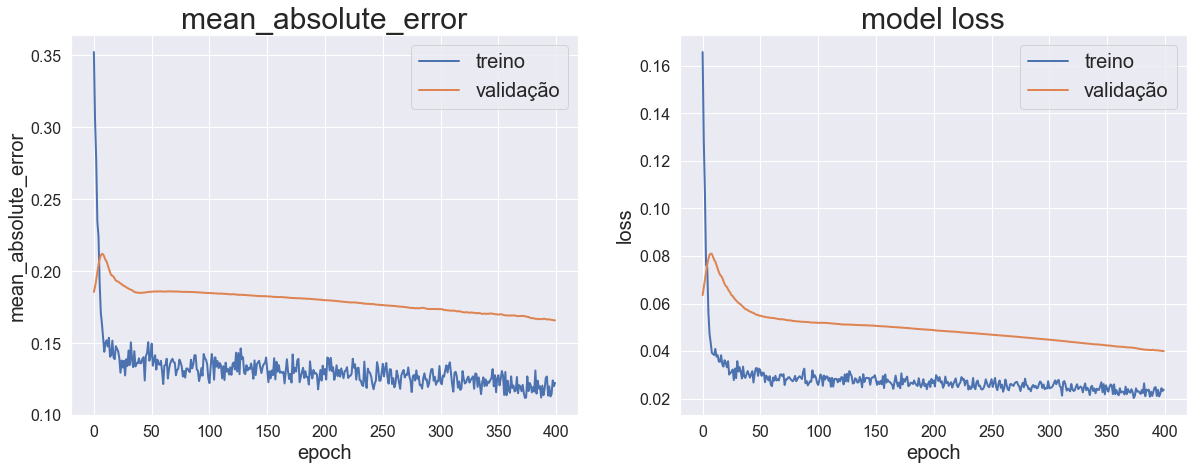

In [183]:
train_plots(modelo)

In [184]:
y_pred = np.squeeze(model.predict(x_test))
y_pred_t = np.squeeze(model.predict(x_train))
y_test_ = y_test[:len(y_pred)]
print(len(y_pred))
print(len(y_test))

18
18


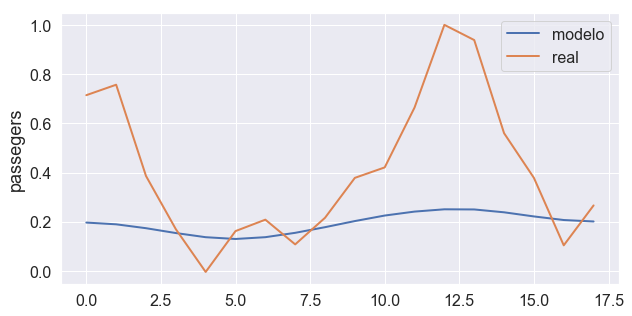

In [204]:
plt.figure(figsize=(10,5))
sns.lineplot(x=range(len(y_pred)), y=y_pred, label="modelo")
sns.lineplot(x=range(len(y_pred)), y=y_test, label="real")

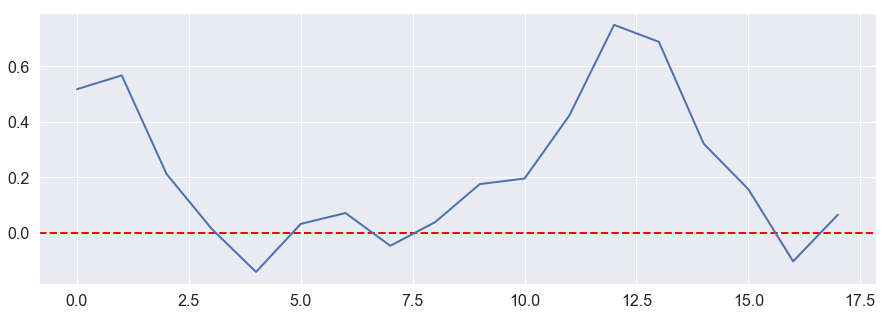

In [205]:
x_graph = np.arange(0, len(y_pred))

plt.figure(figsize=(15,5))
plt.axhline(y=0, color='red', linestyle='--')
plt.plot(x_graph, (y_test_ - y_pred))
plt.show()

MAE treino: 0.1224 (6.12%)
MAE validação: 0.1659 (8.30%)
MAE teste: 0.2511 (12.55%)


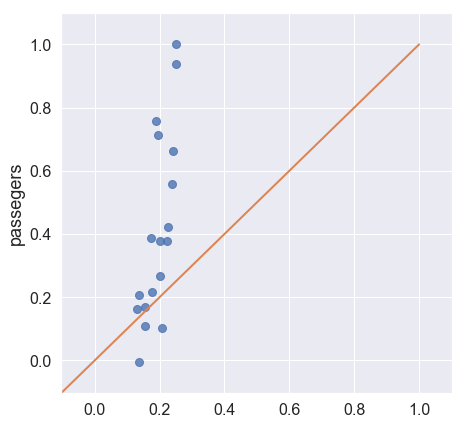

In [187]:
from sklearn.metrics import mean_absolute_error

print('MAE treino: {:.4f}'.format(modelo.history['mean_absolute_error'][-1]), '({:.2f}%)'.format(modelo.history['mean_absolute_error'][-1]/2*100))
print('MAE validação: {:.4f}'.format(modelo.history['val_mean_absolute_error'][-1]), '({:.2f}%)'.format(modelo.history['val_mean_absolute_error'][-1]/2*100))
print('MAE teste: {:.4f}'.format(mean_absolute_error(y_test_,y_pred)), '({:.2f}%)'.format(mean_absolute_error(y_test_,y_pred)/2*100))

plt.figure(figsize=(7,7))
#sns.jointplot(x=y_pred, y=y_test_)

sns.regplot(x=y_pred, y=y_test_, fit_reg = False)
sns.lineplot(x = [-2, 0 ,1], y = [-2, 0 ,1])

plt.ylim((min(min(y_pred), min(y_test_))-0.1,max(max(y_pred), max(y_test_))+0.1))
plt.xlim((min(min(y_pred), min(y_test_))-0.1,max(max(y_pred), max(y_test_))+0.1))
plt.show()

In [188]:
# Faz um comparação entre subidas e decidas, para ver se pelo menos a rede acerta a direção
final = pd.DataFrame({'y_pred':y_pred, 'y_test': y_test_})
final['y_test_1'] = final['y_test'].shift(1)
final['y_pred_1'] = final['y_pred'].shift(1)
final = final.dropna().reset_index(drop = 1)
print(final.head())

aum_test = []
aum_pred = []
for i in range(len(final)):
    if final.iloc[i,1] < final.iloc[i,2]:
        aum_test.append(0)
    else: aum_test.append(1)

    if final.iloc[i,0] < final.iloc[i,3]:
        aum_pred.append(0)
    else: aum_pred.append(1)
        
compara = []

for i in range(len(aum_test)):
    if aum_test[i] == aum_pred[i]:
        compara.append(1)
    else: compara.append(0)

   y_pred  y_test  y_test_1  y_pred_1
0    0.19    0.76      0.71      0.20
1    0.17    0.39      0.76      0.19
2    0.15    0.17      0.39      0.17
3    0.14   -0.00      0.17      0.15
4    0.13    0.16     -0.00      0.14


In [189]:
print('a rede acertou a direção {:.2f}% das vezes'.format(np.count_nonzero(compara)/len(compara)*100))

a rede acertou a direção 76.47% das vezes


---------------------
# Fazendo um pre-processamento antes da LSTM

In [190]:
df.head()

,passegers
date,
1949-01-01,112.00
1949-02-01,118.00
1949-03-01,132.00
1949-04-01,129.00
1949-05-01,121.00


In [191]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

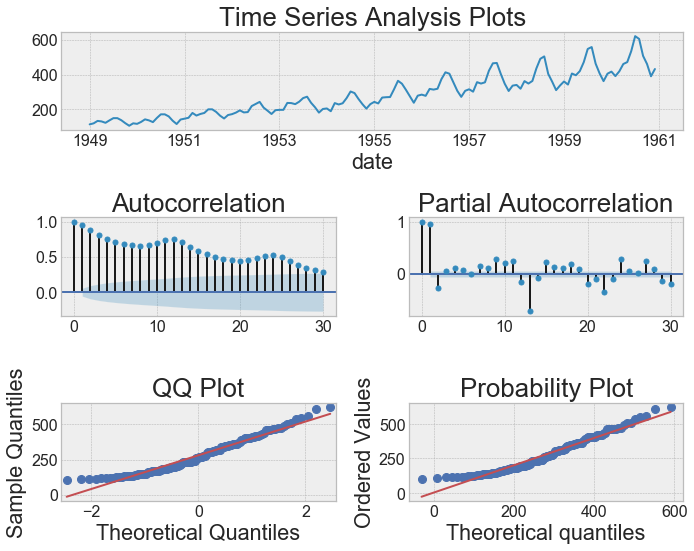

In [206]:
tsplot(df.passegers, lags=30)

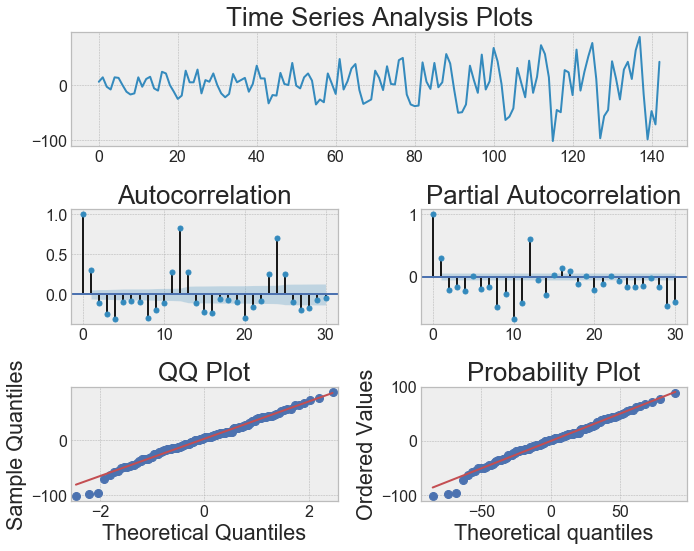

In [207]:
tsplot(np.diff(df.passegers, n= 1), lags=30)

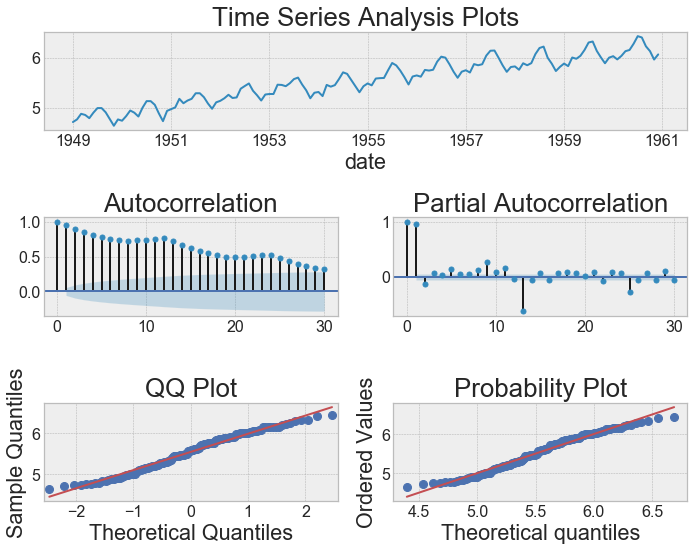

In [208]:
tsplot(np.log(df.passegers), lags=30)

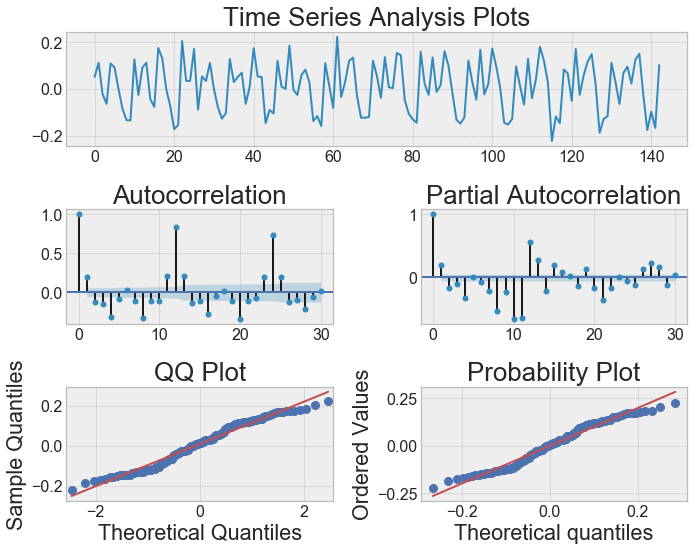

In [209]:
tsplot(np.diff(np.log(df.passegers), n= 1), lags=30)

In [210]:
diff  = np.diff(df.passegers, n= 1)
len(diff)

143

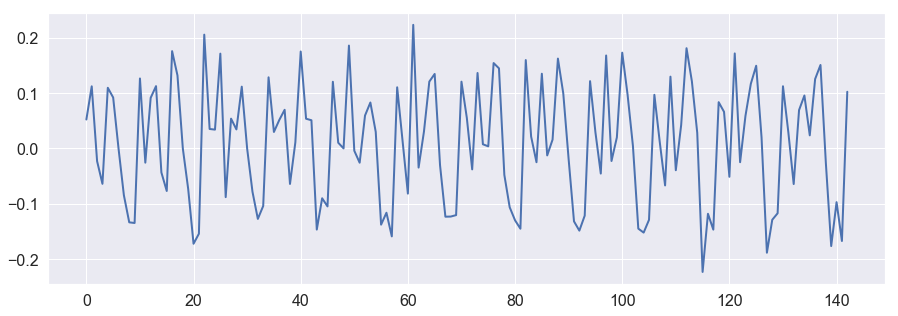

In [211]:
# transforma a serie em estacionaria
diff = np.diff(np.log(df.passegers))
plt.plot(diff)

In [212]:
window_len = 24

In [213]:
diff = pd.DataFrame(diff, columns=['pass_diff'])
diff = transform_df(diff, f_r = (-1, 1))
diff.head()

,pass_diff
0,0.23
1,0.50
2,-0.10
3,-0.29
4,0.49


In [214]:
y = diff['pass_diff'].shift(-window_len)
print(len(y))
print(y[:10])

143
0    0.15
1    0.77
2   -0.39
3    0.24
4    0.15
5    0.50
6    0.00
7   -0.35
8   -0.57
9   -0.47
Name: pass_diff, dtype: float64


In [215]:
y = y.dropna()
len(y)

119

In [216]:
data_lstm = create_inputs(diff.values, window_len = window_len)
data_lstm = np.array(data_lstm)
data_lstm.shape

(119, 24, 1)

In [217]:
data_lstm = data_lstm[:len(y),:,:]
data_lstm.shape

(119, 24, 1)

In [218]:
x_train,y_train,x_val,y_val,x_test,y_test = train_test_split(data_lstm,
                                                             y,
                                                             train_split = 0.7, 
                                                             test_split = 0.15)

83
17
17
(83, 24, 1)
(83,)
(17, 24, 1)
(17,)
(19, 24, 1)
(19,)


In [224]:
experimento   = 'teste04_diff'
neurons       = 30             
loss          = 'mean_squared_error'
activ_func    = 'relu'
#optimizer    = Adadelta(lr=0.0001, rho=0.95, epsilon=None, decay=0.0) 
optimizer     = RMSprop(lr=0.0001, rho=0.95, epsilon=None, decay=0.0)
dropout       = 0.25                 
batch_size    = 5               
epochs        = 300                  

# initialise model architecture
model = build_model(x_train, 
                    output_size=1,
                    neurons = neurons,
                    activ_func = activ_func,
                    loss = loss,
                    optimizer = optimizer,
                    dropout=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 24, 30)            3840      
_________________________________________________________________
dropout_82 (Dropout)         (None, 24, 30)            0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_83 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [225]:
callback = ModelCheckpoint( filepath='pesos/weights.'+ experimento +'.hdf5', 
                            verbose=1, 
                            save_best_only=True
                          )

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0, 
                      patience=100, 
                      verbose=-1, 
                      mode='auto'
                     )

modelo2 = model.fit(x_train, 
                    y_train,
                    epochs=epochs, 
                    batch_size=batch_size,
                    verbose=2, 
                    validation_data=(x_val, y_val), 
                    shuffle=False,
                    callbacks=[callback,
                               early 
                              ])

Train on 83 samples, validate on 17 samples
Epoch 1/300
 - 8s - loss: 0.2125 - mean_absolute_error: 0.3869 - val_loss: 0.2383 - val_mean_absolute_error: 0.4091

Epoch 00001: val_loss improved from inf to 0.23831, saving model to pesos/weights.teste04_diff.hdf5
Epoch 2/300
 - 1s - loss: 0.2102 - mean_absolute_error: 0.3844 - val_loss: 0.2366 - val_mean_absolute_error: 0.4078

Epoch 00002: val_loss improved from 0.23831 to 0.23663, saving model to pesos/weights.teste04_diff.hdf5
Epoch 3/300
 - 1s - loss: 0.2104 - mean_absolute_error: 0.3845 - val_loss: 0.2352 - val_mean_absolute_error: 0.4066

Epoch 00003: val_loss improved from 0.23663 to 0.23516, saving model to pesos/weights.teste04_diff.hdf5
Epoch 4/300
 - 1s - loss: 0.2083 - mean_absolute_error: 0.3832 - val_loss: 0.2337 - val_mean_absolute_error: 0.4054

Epoch 00004: val_loss improved from 0.23516 to 0.23369, saving model to pesos/weights.teste04_diff.hdf5
Epoch 5/300
 - 1s - loss: 0.2073 - mean_absolute_error: 0.3812 - val_loss: 0

Epoch 83/300
 - 1s - loss: 0.1275 - mean_absolute_error: 0.3013 - val_loss: 0.2032 - val_mean_absolute_error: 0.3614

Epoch 00083: val_loss did not improve from 0.17572
Epoch 84/300
 - 1s - loss: 0.1270 - mean_absolute_error: 0.3068 - val_loss: 0.2026 - val_mean_absolute_error: 0.3605

Epoch 00084: val_loss did not improve from 0.17572
Epoch 85/300
 - 1s - loss: 0.1268 - mean_absolute_error: 0.3012 - val_loss: 0.2045 - val_mean_absolute_error: 0.3616

Epoch 00085: val_loss did not improve from 0.17572
Epoch 86/300
 - 1s - loss: 0.1286 - mean_absolute_error: 0.3065 - val_loss: 0.2084 - val_mean_absolute_error: 0.3650

Epoch 00086: val_loss did not improve from 0.17572
Epoch 87/300
 - 1s - loss: 0.1317 - mean_absolute_error: 0.3080 - val_loss: 0.2025 - val_mean_absolute_error: 0.3598

Epoch 00087: val_loss did not improve from 0.17572
Epoch 88/300
 - 1s - loss: 0.1245 - mean_absolute_error: 0.2972 - val_loss: 0.2004 - val_mean_absolute_error: 0.3580

Epoch 00088: val_loss did not improve


Epoch 00131: val_loss did not improve from 0.17572
Epoch 132/300
 - 1s - loss: 0.1114 - mean_absolute_error: 0.2714 - val_loss: 0.2102 - val_mean_absolute_error: 0.3679

Epoch 00132: val_loss did not improve from 0.17572
Epoch 133/300
 - 1s - loss: 0.1217 - mean_absolute_error: 0.2937 - val_loss: 0.2101 - val_mean_absolute_error: 0.3682

Epoch 00133: val_loss did not improve from 0.17572
Epoch 134/300
 - 1s - loss: 0.1168 - mean_absolute_error: 0.2832 - val_loss: 0.2093 - val_mean_absolute_error: 0.3674

Epoch 00134: val_loss did not improve from 0.17572
Epoch 135/300
 - 1s - loss: 0.1107 - mean_absolute_error: 0.2725 - val_loss: 0.2154 - val_mean_absolute_error: 0.3732

Epoch 00135: val_loss did not improve from 0.17572
Epoch 136/300
 - 1s - loss: 0.1141 - mean_absolute_error: 0.2836 - val_loss: 0.2123 - val_mean_absolute_error: 0.3700

Epoch 00136: val_loss did not improve from 0.17572
Epoch 137/300
 - 1s - loss: 0.1236 - mean_absolute_error: 0.2928 - val_loss: 0.2077 - val_mean_abs

In [226]:
# Carrega os pesos salvos para a melhor validação do treino
model.load_weights('pesos/weights.' + experimento + '.hdf5')

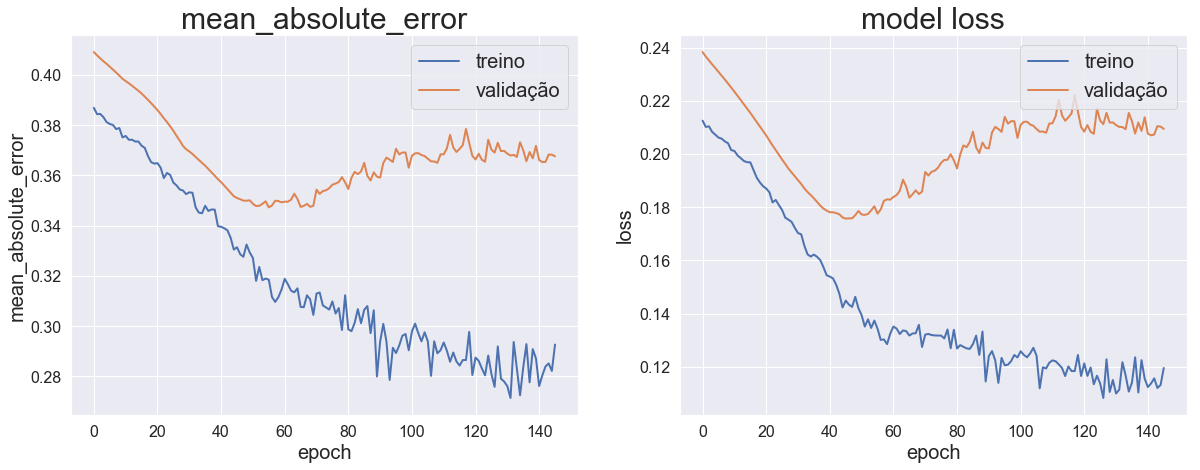

In [227]:
train_plots(modelo2)

In [228]:
y_pred = np.squeeze(model.predict(x_test))
y_pred_t = np.squeeze(model.predict(x_train))
y_test_ = y_test[:len(y_pred)]
x_graph = np.arange(0, len(y_pred))
print(len(y_pred))
print(len(y_test))

19
19


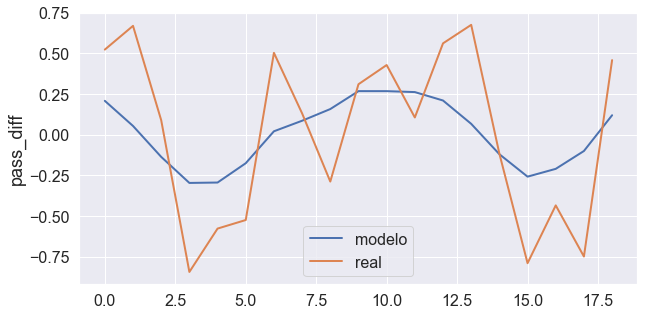

In [229]:
plt.figure(figsize=(10,5))
sns.lineplot(x=range(len(y_pred)), y=y_pred, label="modelo")
sns.lineplot(x=range(len(y_pred)), y=y_test, label="real")

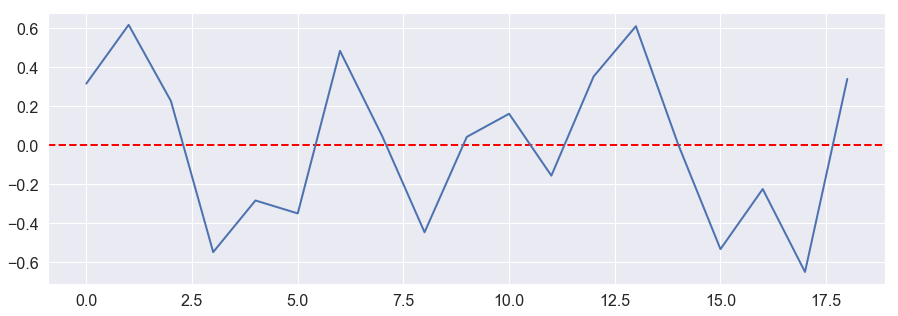

In [230]:
x_graph = np.arange(0, len(y_pred))

plt.figure(figsize=(15,5))
plt.axhline(y=0, color='red', linestyle='--')
plt.plot(x_graph, (y_test_ - y_pred))
plt.show()

In [155]:
x_graph = np.arange(0, len(y_pred))
print(len(y_test_))
print(len(y_pred))

19
19


MAE treino: 0.1224 (6.12%)
MAE validação: 0.1659 (8.30%)
MAE teste: 0.3357 (16.78%)


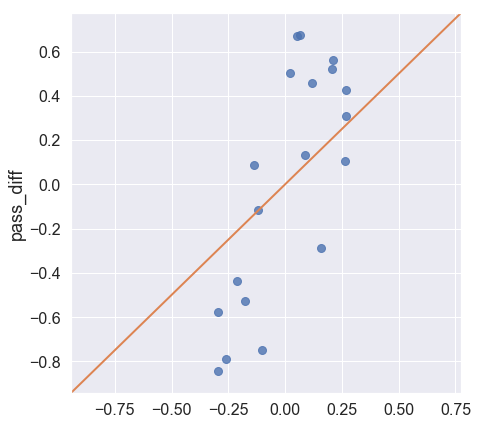

In [231]:
from sklearn.metrics import mean_absolute_error

print('MAE treino: {:.4f}'.format(modelo.history['mean_absolute_error'][-1]), '({:.2f}%)'.format(modelo.history['mean_absolute_error'][-1]/2*100))
print('MAE validação: {:.4f}'.format(modelo.history['val_mean_absolute_error'][-1]), '({:.2f}%)'.format(modelo.history['val_mean_absolute_error'][-1]/2*100))
print('MAE teste: {:.4f}'.format(mean_absolute_error(y_test_,y_pred)), '({:.2f}%)'.format(mean_absolute_error(y_test_,y_pred)/2*100))

plt.figure(figsize=(7,7))
#sns.jointplot(x=y_pred, y=y_test_)

sns.regplot(x=y_pred, y=y_test_, fit_reg = False)
sns.lineplot(x = [-2, 0 ,1], y = [-2, 0 ,1])

plt.ylim((min(min(y_pred), min(y_test_))-0.1,max(max(y_pred), max(y_test_))+0.1))
plt.xlim((min(min(y_pred), min(y_test_))-0.1,max(max(y_pred), max(y_test_))+0.1))
plt.show()

In [233]:
final = pd.DataFrame({'y_pred':y_pred, 'y_test': y_test_})
final['y_test_1'] = final['y_test'].shift(1)
final['y_pred_1'] = final['y_pred'].shift(1)

aum_test = []
aum_pred = []
for i in range(len(final)):
    if final.iloc[i,1] < final.iloc[i,2]:
        aum_test.append(0)
    else: aum_test.append(1)

    if final.iloc[i,0] < final.iloc[i,3]:
        aum_pred.append(0)
    else: aum_pred.append(1)
        
compara = []

for i in range(len(aum_test)):
    if aum_test[i] == aum_pred[i]:
        compara.append(1)
    else: compara.append(0)

In [235]:
print('a rede acertou a direção {:.2f}% das vezes'.format(np.count_nonzero(compara)/len(compara)*100))

a rede acertou a direção 63.16% das vezes


--------------------------
# FaceBook Prophet

In [236]:
from fbprophet import Prophet

In [237]:
df = pd.read_csv('data/international-airline-passengers.csv')
df = df[:-1]
# manually specify column names
df.columns = ['ds','y']
df['ds'] =  pd.to_datetime(df['ds'], format='%Y-%m')
df.tail()

,ds,y
139,1960-08-01,606.00
140,1960-09-01,508.00
141,1960-10-01,461.00
142,1960-11-01,390.00
143,1960-12-01,432.00


In [238]:
df.y = np.log(df.y)
df_train = df[:100].copy()
df_test = df[100:].copy()
len(df_test)

44

In [239]:
m1 = Prophet()
m1.fit(df_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [240]:
future1 = m1.make_future_dataframe(periods=len(df_test), freq = 'M')
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-07-31,6.45,6.19,6.68
140,1960-08-31,6.37,6.11,6.61
141,1960-09-30,6.22,5.96,6.46
142,1960-10-31,6.07,5.78,6.33
143,1960-11-30,6.22,5.93,6.48


In [241]:
np.exp(forecast1[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
139,630.11,489.05,793.92
140,583.91,450.72,740.08
141,501.63,385.72,640.35
142,432.90,323.79,561.54
143,504.94,377.44,654.17


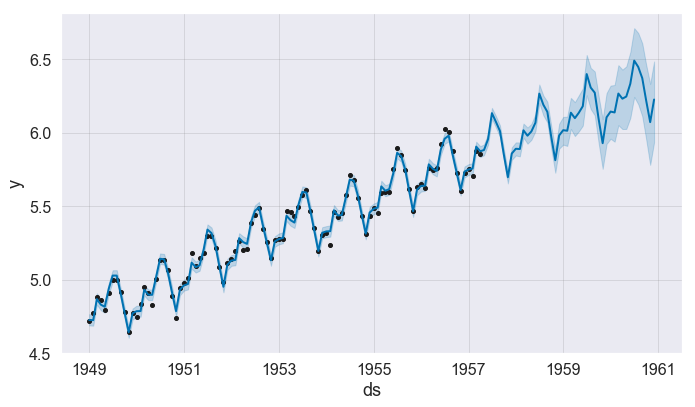

In [242]:
m1.plot(forecast1);

In [243]:
d = {'date':df_test['ds'], 'y_test': df_test['y'], 'y_pred': forecast1['yhat'][100:]}
df_comp = pd.DataFrame(data=d)
df_comp.head()

,date,y_test,y_pred
100,1957-05-01,5.87,5.88
101,1957-06-01,6.05,5.95
102,1957-07-01,6.14,6.13
103,1957-08-01,6.15,6.07
104,1957-09-01,6.00,6.01


In [244]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_comp.y_test, df_comp.y_pred)*100

8.703666072797885

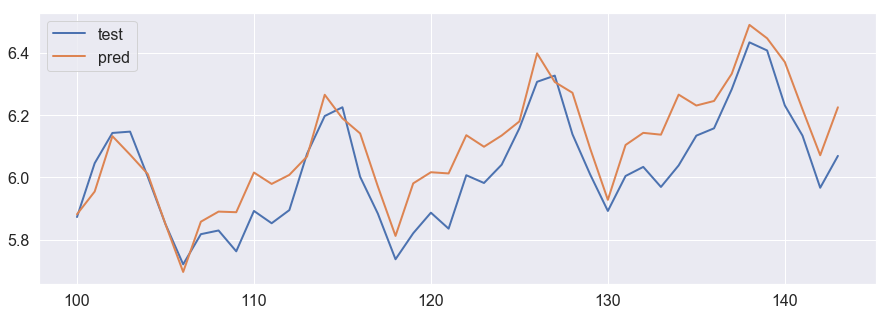

In [245]:
plt.plot(df_comp.y_test, label='test')
plt.plot(df_comp.y_pred, label='pred')
plt.legend(loc='upper left')

## Removendo a tendencia

In [246]:
df = pd.read_csv('data/international-airline-passengers.csv')
df = df[:-1]
# manually specify column names
df.columns = ['ds','y']
df['ds'] =  pd.to_datetime(df['ds'], format='%Y-%m')
df.head()

,ds,y
0,1949-01-01,112.00
1,1949-02-01,118.00
2,1949-03-01,132.00
3,1949-04-01,129.00
4,1949-05-01,121.00


In [247]:
y = np.diff(np.log(df.y))

In [248]:
df = df[1:]
df['y'] = y

df = df.dropna()
df_train = df[:100].copy()
df_test = df[100:].copy()
len(df_test)

43

In [249]:
m2 = Prophet()
m2.fit(df_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [250]:
future2 = m2.make_future_dataframe(periods=len(df_test), freq = 'M')
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
138,1960-07-31,-0.01,-0.05,0.03
139,1960-08-31,-0.11,-0.16,-0.07
140,1960-09-30,-0.13,-0.18,-0.09
141,1960-10-31,-0.13,-0.17,-0.09
142,1960-11-30,0.13,0.09,0.18


In [251]:
np.exp(forecast2[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
138,0.99,0.95,1.03
139,0.89,0.86,0.93
140,0.87,0.84,0.92
141,0.88,0.84,0.91
142,1.14,1.09,1.19


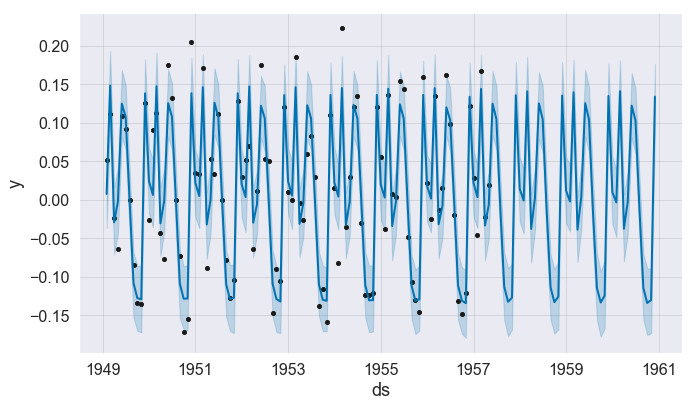

In [252]:
m2.plot(forecast2);

In [253]:
print(len(df_test))
print(len(forecast2[100:]))
print(len(df))

43
43
143


In [254]:
df_test.head()

,ds,y
101,1957-06-01,0.17
102,1957-07-01,0.10
103,1957-08-01,0.00
104,1957-09-01,-0.14
105,1957-10-01,-0.15


In [255]:
f = forecast2[['yhat', 'yhat_lower', 'yhat_upper']][100:]
f.head()

,yhat,yhat_lower,yhat_upper
100,0.13,0.08,0.17
101,0.11,0.06,0.15
102,-0.01,-0.05,0.03
103,-0.11,-0.16,-0.07
104,-0.13,-0.18,-0.09


In [256]:
d = {'date':df_test['ds'], 'y_test': df_test['y']}
df_comp = pd.DataFrame(data=d)
df_comp['y_pred'] =  f.yhat.values
df_comp.head()

,date,y_test,y_pred
101,1957-06-01,0.17,0.13
102,1957-07-01,0.10,0.11
103,1957-08-01,0.00,-0.01
104,1957-09-01,-0.14,-0.11
105,1957-10-01,-0.15,-0.13


In [257]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_comp.y_test, df_comp.y_pred)*100

3.5819634526837794

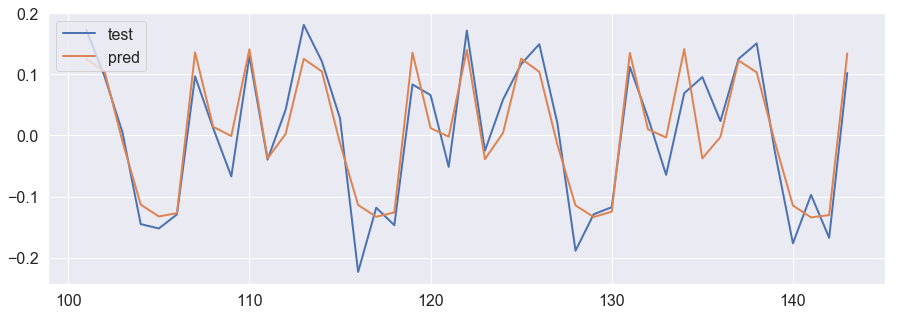

In [258]:
plt.plot(df_comp.y_test, label='test')
plt.plot(df_comp.y_pred, label='pred')
plt.legend(loc='upper left')

Resultado: o Prophet se mostrou melhor que a LSTM nesse caso, pois, além de treinar muito mais rápido, obteve respostas com menor erro, entre os modelos do Prophet, o que houve remoção de tendencia prévia teve um erro menor do que o com tendencia.